In [1]:
import geopandas as gpd
import mapclassify  # required for scheme=... in GeoPandas plots
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("geopandas:", gpd.__version__)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("mapclassify:", mapclassify.__version__)

geopandas: 1.1.2
pandas: 3.0.0
numpy: 2.3.5
matplotlib: 3.10.8
mapclassify: 2.10.0


In [14]:
import geopandas as gpd

gdf = gpd.read_file("geovis_labs/lab5/pop.gpkg")  # <-- change path
print("CRS:", gdf.crs)
print("Bounds:", gdf.total_bounds)
print("Columns:", list(gdf.columns))
print(gdf.head())

CRS: EPSG:3857
Bounds: [-8893188.4426  5404091.0751 -8864401.1735  5441905.9607]
Columns: ['CTUID', 'CTNAME', 'PRUID', 'POPULATION_2021', 'POPULATION_2016', 'POP_CHANGE_2016_TO_2021', 'TOTAL_PRIVATE_DWELLINGS', 'PRIVATE_DWELL_OCCUPIED', 'LAND_AREA_KM2', 'POP_DENSITY_PER_KM2', 'geometry']
        CTUID   CTNAME PRUID  POPULATION_2021  POPULATION_2016  \
0  5350573.06  0573.06    35             4611             4598   
1  5350573.07  0573.07    35             6129             5818   
2  5350576.16  0576.16    35             6366             6468   
3  5350576.17  0576.17    35             6724             6767   
4  5350573.09  0573.09    35             6086             6060   

   POP_CHANGE_2016_TO_2021  TOTAL_PRIVATE_DWELLINGS  PRIVATE_DWELL_OCCUPIED  \
0                      0.3                     1452                    1419   
1                      5.3                     2307                    2217   
2                     -1.6                     1677                    1607  

### 7. What does CRS mean, and why does it matter for mapping and area-based distortion?

<b>Answer:</b> CRS mean the coordinate reference system which define the 3D earth surface on a 2D map. To maintain the different properties of the shape area CRS matter. Some CRS preserve the actual shape and some CRS preserve the area but not the shape. Some CRS good for distance measurement. Based on the mapping and area-based distortion CRS matter.

### 8. What does gdf.total_bounds return, and how would you use it to sanity-check your data?

<b>Answer:</b> The <i>gdf.total_bounds</i> returns the extreme four coordinates of our shape, which is the bounding box of the area of interest. Based on the defined CRS, the value changes. If the value is between 90 and 180, the CRS is a geographic coordinate system; if the value is very large, such as 8893188, the CRS is a projected coordinate system. It is a recheck mechanism that ensures that our data is in the right projection system.

### 9. Which line reprojects the data, and what would happen if WORK_EPSG is invalid?

<b>Answer:</b> <i>gdf.to_crs</i> reproject the data. If <i>WORK_EPSG</i> is invalid then the area of interest will reproject to a different place where it should not be. Sometimes due to the invalid EPSG the area of interest can be in the middle of oceane or in the pole. So due to invalid EPSG the area of interest does not align with its actual boundary.

In [15]:
VAR = "POPULATION_2021"  # <-- change
gdf[VAR] = pd.to_numeric(gdf[VAR], errors="coerce")
print("Missing values:", gdf[VAR].isna().sum())
print(gdf[VAR].describe())

Missing values: 0
count      122.000000
mean      5380.983607
std       2761.294322
min       1192.000000
25%       4015.500000
50%       5107.500000
75%       6436.750000
max      29669.000000
Name: POPULATION_2021, dtype: float64


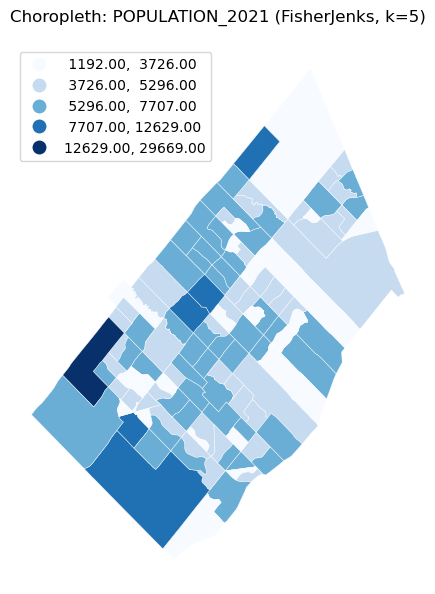

In [17]:
import matplotlib.pyplot as plt

ax = gdf.plot(
    column=VAR,
    scheme="FisherJenks",  # try: "EqualInterval", "FisherJenks", "Quantiles"
    k=5,
    cmap="Blues",
    linewidth=0.3,
    edgecolor="white",
    legend=True,
    legend_kwds={"loc": "upper left"},
    figsize=(9, 7),
)
ax.set_title(f"Choropleth: {VAR} (FisherJenks, k=5)")
ax.set_axis_off()
plt.show()

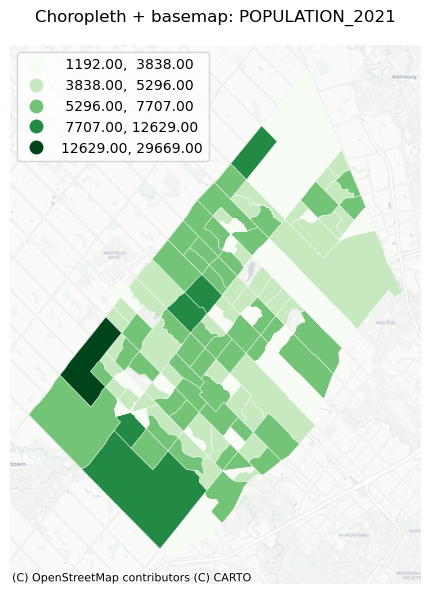

In [47]:
# Optional basemap (requires: contextily)
import contextily as cx

gdf_web = gdf.to_crs(epsg=3857)
ax = gdf_web.plot(
    column=VAR,
    scheme="FisherJenks",
    k=5,
    cmap="Greens",
    linewidth=0.3,
    edgecolor="white",
    legend=True,
    legend_kwds={"loc": "upper left"},
    figsize=(9, 7),
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_title(f"Choropleth + basemap: {VAR}")
ax.set_axis_off()
plt.show()

### 10. Which parameter controls the number of classes (bins)?

<b>Answer:</b> The parameter <i>k</i> controls the number of classes (bins).

### 11. Which parameter changes the color palette? Give two valid cmap examples.

<b>Answer:</b> The parameter <i>cmap</i> changers the color plaette. Two valid cmap examples: <b>viridis</b> and <b>Greens</b>

### 12. Which parameters control polygon boundary appearance (color and line width)?

<b>Answer:</b> The parameter <i>edgecolor</i> control the polygon boundary color appearance and <i>linewidth</i> control the line width.

### 13. What does scheme='Quantiles' mean, and how is it different from 'EqualInterval'?

<b>Answer:</b> The <i>scheme="Quantiles"</i> mean it divided the class into approximately same number of feature whereas <i>"EqualInterval"</i> divided the class into equal range based on maximum and minimum value. So, one scheme divided the class based on number of feature and other scheme divide the class based on equal value.

In [52]:
X = "POP_DENSITY_PER_KM2"  # <-- change
Y = "LAND_AREA_KM2"  # <-- change
N = 4  # number of bins per variable (3 -> 3x3)
gdf[X] = pd.to_numeric(gdf[X], errors="coerce")
gdf[Y] = pd.to_numeric(gdf[Y], errors="coerce")
# Quantile bins (0..N-1). duplicates='drop' avoids errors if many ties.
gdf["x_bin"] = pd.qcut(gdf[X], N, labels=False, duplicates="drop")
gdf["y_bin"] = pd.qcut(gdf[Y], N, labels=False, duplicates="drop")
# Combine bins into one class ID (row-major)
gdf["bi_class"] = gdf["y_bin"] * N + gdf["x_bin"]

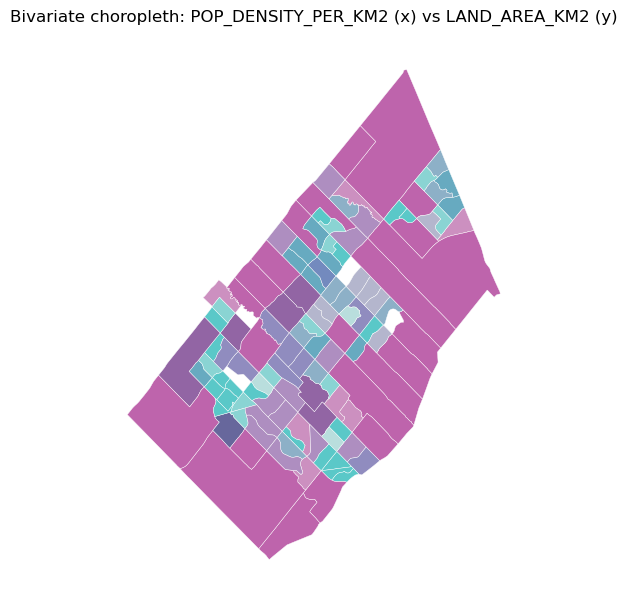

In [54]:
# 4x4 bivariate palette (row-major: y from low->high, x from low->high)
palette = [ "#e8e8e8", "#b9dedd", "#8ad4d3", "#5ac8c8",
            "#dabcd4", "#b4b6cd", "#8db0c7", "#67aac0",
            "#cc90c0", "#ae8ec0", "#908cbf", "#738abe",
            "#be64ac", "#9265a4", "#67679c", "#3b4994",
]


def class_to_color(v):
    if pd.isna(v):
        return "#dddddd"
    return palette[int(v)]


gdf["bi_color"] = gdf["bi_class"].apply(class_to_color)

ax = gdf.plot(color=gdf["bi_color"], linewidth=0.3, edgecolor="white", figsize=(9, 7))
ax.set_title(f"Bivariate choropleth: {X} (x) vs {Y} (y)")
ax.set_axis_off()
plt.show()

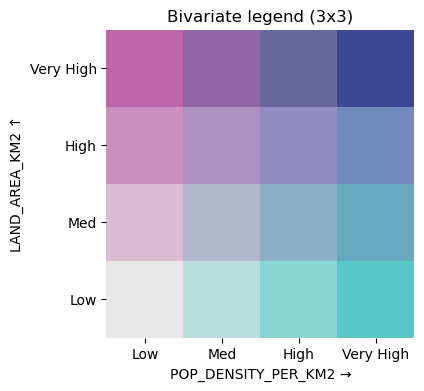

In [55]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(4, 4))
for y in range(N):
    for x in range(N):
        idx = y * N + x
        ax.add_patch(Rectangle((x, y), 1, 1, facecolor=palette[idx], edgecolor="none"))
ax.set_xlim(0, N)
ax.set_ylim(0, N)
ax.set_aspect("equal")


# Minimal labeling (edit these to match your variables)
ax.set_xticks([0.5, 1.5, 2.5, 3.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5])
ax.set_xticklabels(["Low", "Med", "High", "Very High"])
ax.set_yticklabels(["Low", "Med", "High", "Very High"])
ax.set_xlabel(X + " →")
ax.set_ylabel(Y + " ↑")

# Clean look
for spine in ax.spines.values():
    spine.set_visible(False)

plt.title("Bivariate legend (3x3)")
plt.show()

### 14. What does pd.qcut do, and why might duplicates='drop' be necessary?

<b>Answer:</b> <i> pd.qcut</i> divides the data using quantiles, and <i>duplicates='drop'</i> prevents errors by merging bins if the data contains so many identical values (e.g., many zeros).

### 15. How is bi_class computed? Explain the formula in one sentence.

<b>Answer:</b> The <i>bi_class </i> is computed by multiplying the Y variable's bin index by N (number of bins, e.g, if 3x3 then 3 and for 4x4 then 4) and adding the X variable's bin index.

### 16. Which lines would you change to switch from a 3x3 to a 4x4 bivariate map?

<b>Answer:</b> To switch from a 3x3 to a 4x4, we have to make changes in three places, first <i>N=4</i>, switch the color plate to 16 color scheme and third to make changes in the legend switch <i>xticks</i> and <i>yticks</i> into 4 class.

### 17. Which variable controls the colors used for the map?

<b>Answer:</b> <i>palette</i> variable controls the colors used fr the map.

In [36]:
CART_FIELD = "POP_DENSITY_PER_KM2"  # <-- change
gdf[CART_FIELD] = pd.to_numeric(gdf[CART_FIELD], errors="coerce")
gdf = gdf.dropna(subset=[CART_FIELD]).copy()
# Cartograms require positive values
gdf = gdf[gdf[CART_FIELD] > 0].copy()
print(gdf[CART_FIELD].describe())

count     118.000000
mean     4361.029661
std      1974.950160
min       118.300000
25%      3228.875000
50%      4426.900000
75%      5710.825000
max      7836.700000
Name: POP_DENSITY_PER_KM2, dtype: float64


Average residual area error: 13.059683275351764


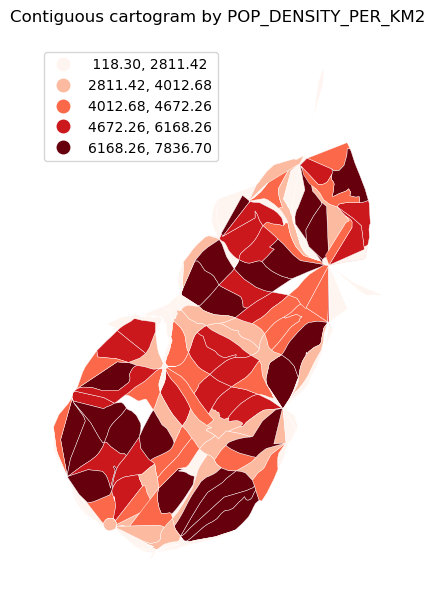

In [39]:
# Requires: pip install cartogram
import cartogram
import matplotlib.pyplot as plt

c = cartogram.Cartogram(
    gdf,
    CART_FIELD,
    max_iterations=99,  # try: 30, 60, 99
    max_average_error=0.01,  # try: 0.10 (faster) -> 0.02 (more accurate)
)
print("Average residual area error:", c.average_error)
ax = c.plot(
    column=CART_FIELD,
    scheme="Quantiles",
    k=5,
    cmap="Reds",
    linewidth=0.3,
    edgecolor="white",
    legend=True,
    legend_kwds={"loc": "upper left"},
    figsize=(9, 7),
)
ax.set_title(f"Contiguous cartogram by {CART_FIELD}")
ax.set_axis_off()
plt.show()
# Optional export
c.to_file("geovis_labs/lab5/outputs/cartogram.gpkg", layer="cartogram", driver="GPKG")

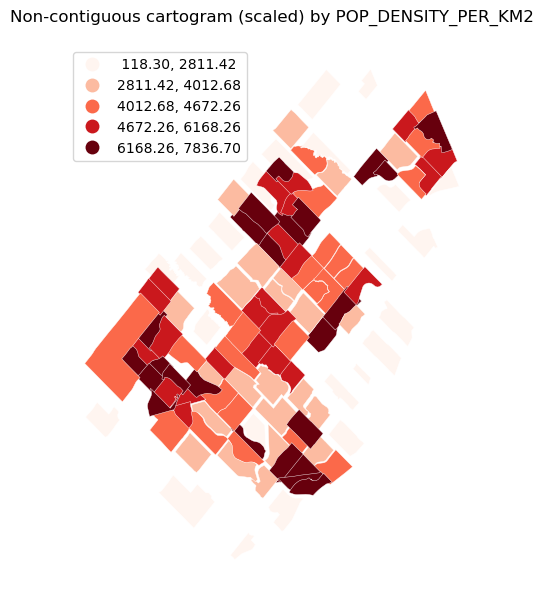

In [43]:
from shapely.affinity import scale

vals = gdf[CART_FIELD].to_numpy()
factors = np.sqrt(vals / np.nanmean(vals))  # area is ~factor^2
scaled_geoms = [
    scale(geom, xfact=f, yfact=f, origin="center")
    for geom, f in zip(gdf.geometry, factors)
]
gdf_scaled = gdf.copy()
gdf_scaled["geometry_scaled"] = scaled_geoms
gdf_scaled = gdf_scaled.set_geometry("geometry_scaled")
ax = gdf_scaled.plot(
    column=CART_FIELD,
    scheme="Quantiles",
    k=5,
    cmap="Reds",
    linewidth=0.3,
    edgecolor="white",
    legend=True,
    legend_kwds={"loc": "upper left"},
    figsize=(9, 7),
)
ax.set_title(f"Non-contiguous cartogram (scaled) by {CART_FIELD}")
ax.set_axis_off()
plt.show()

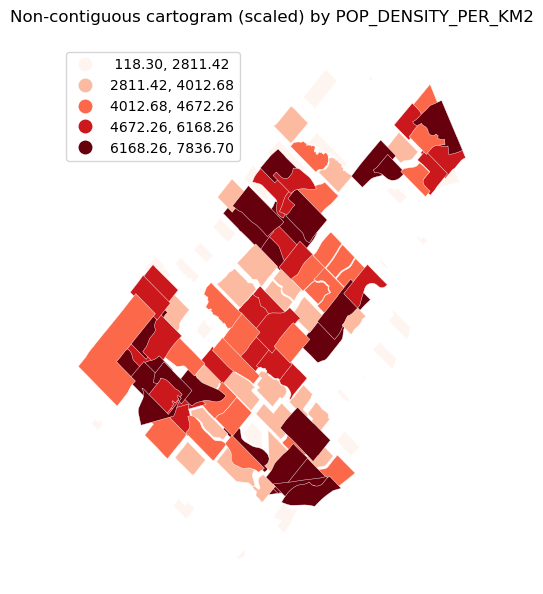

In [44]:
from shapely.affinity import scale

vals = gdf[CART_FIELD].to_numpy()
factors = (vals / np.nanmean(vals))  # area is ~factor^2
scaled_geoms = [
    scale(geom, xfact=f, yfact=f, origin="center")
    for geom, f in zip(gdf.geometry, factors)
]
gdf_scaled = gdf.copy()
gdf_scaled["geometry_scaled"] = scaled_geoms
gdf_scaled = gdf_scaled.set_geometry("geometry_scaled")
ax = gdf_scaled.plot(
    column=CART_FIELD,
    scheme="Quantiles",
    k=5,
    cmap="Reds",
    linewidth=0.3,
    edgecolor="white",
    legend=True,
    legend_kwds={"loc": "upper left"},
    figsize=(9, 7),
)
ax.set_title(f"Non-contiguous cartogram (scaled) by {CART_FIELD}")
ax.set_axis_off()
plt.show()

### 18. Why must the cartogram field be positive?

<b>Answer:</b> The cartogram field must be positive because, during reverse engineering, the cartogram uses the <b>square root</b>. The square root of a negative value is <b>inf</b>, so if the cartogram value is negative, then reverse engineering will fail. 

### 19. What do max_iterations and max_average_error control?

<b>Answer:</b> <u><i>max_iterations</i></u> is the number of times the function will iterate, and <u><i>max_average_error</i></u> is the maximum error we decided to have in our function. So, the model ends when it reaches either <u><i>max_iterations</i></u> or <u><i>max_average_error</i></u>. So, this two-function control model runs the time.

### 20. What is c.average_error measuring (in plain language)?

<b>Answer:</b> <i> c.average_error </i> simiply measure the accuray of the shape in cartogram. So, it measures the distortion of the shape.

### 21. In the fallback method, why do we use sqrt(value/mean) rather than value/mean directly?

<b>Answer:</b> In the fallback method, we use <i>sqrt(value/mean)</i> rather than <i>value/mean</i> to maintain the actual geometry more accurately. Using <i>value/mean</i> distorted the shape geometry disproportionately.